In [ ]:
!apt-get install nvidia-cuda-toolkit
!pip3 install numba
!pip install wurlitzer

In [1]:
import math
from random import random, shuffle, gauss, sample, seed
from matplotlib import pyplot as plt
from numba import cuda
import numpy
import numba
from numba import njit
from numpy import inf

@njit
def my_inf():
    return inf

In [2]:
def random_data(n, c):
    l = [[gauss(0.5, 0.1) + j, gauss(0.5, 0.1)] for j in range(c) for i in range(n)]
    shuffle(l)
    return l

In [3]:
def init_particles(n_particles, n_clusters, data):
    particles_pos = []
    particles_vel = []
    data = data.tolist()
    for i in range(n_particles):
        l2 = []
        clusters = sample(data, n_clusters)
        for cluster in clusters:
            l2.extend(cluster)
        particles_pos.append(l2)
        particles_vel.append([random() * 0.5 - 0.25 for i in range(n_clusters * len(data[0]))])
    print("chal rha hai")
    return particles_pos, particles_vel

In [4]:
@cuda.jit
def fitness_GPU(particles_pos, data, num_particles, particle_fitness):
    index = cuda.grid(1)
    tempData = cuda.shared.array(shape=(BLOCKDIM, DATADIM), dtype=numba.float64)
    data_dim = data.shape[1]

    if index < num_particles:
        particle = particles_pos[index]
        
    sum_dists = 0

    phases = (data.shape[0] - 1) // BLOCKDIM + 1
    for phase in range(phases):
        if phase * BLOCKDIM + cuda.threadIdx.x < data.shape[0]:
            for d in range(DATADIM):
                tempData[cuda.threadIdx.x, d] = data[phase * BLOCKDIM + cuda.threadIdx.x, d]
        else:
            for d in range(DATADIM):
                tempData[cuda.threadIdx.x, d] = 0

        cuda.syncthreads()              

        if index < num_particles:
            for point in range(tempData.shape[0]):
                if point + BLOCKDIM * phase < data.shape[0]:
                    min_dist = my_inf()
                    for centroid in range(0, particle.shape[0], data_dim):
                        dist = 0
                        for k in range(data_dim):
                            dist += (tempData[point, k] - particle[centroid + k]) ** 2
                        if(dist < min_dist):
                            min_dist = dist
                    sum_dists += min_dist

        cuda.syncthreads()

    if index < num_particles:
        particle_fitness[index] = sum_dists #/ data.shape[0]

In [5]:
@cuda.jit
def update_GPU(particles_pos, particles_vel, particles_best_pos, global_best_pos, w, c1, c2, random_numbers, num_particles):
    start = cuda.grid(1)
    stride = cuda.blockDim.x * cuda.gridDim.x
    for i in range(start, num_particles, stride):
        r1 = random_numbers[i * 2]
        r2 = random_numbers[i * 2 + 1]
        for d in range(len(particles_pos[i])):
            particles_vel[i][d] = w * particles_vel[i][d] + c1 * r1 * (particles_best_pos[i][d] - particles_pos[i][d]) + c2 * r2 * (global_best_pos[d] - particles_pos[i][d])
            particles_pos[i][d] += particles_vel[i][d]

In [6]:
@cuda.jit
def find_max(fitness, x):
    x[0] = fitness.argmax()


In [7]:
def main_GPU(
        data,
        n = 10000,
        particles = 10000,
        iterations = 100,
        c = 3,
        w = 0.99,
        c1 = 0.3,
        c2 = 0.3,
        blockdim = 64
    ):
    griddim = (particles - 1) // blockdim + 1
    
    #visual profiler
    #jit profiler
    #jit exploration
    #parameter optimization
    #kmeans integration: numba vs (paper) existing implementation
        
    particles_pos, particles_vel = init_particles(particles, c, data)
    particles_pos = numpy.array(particles_pos)
    particles_vel = numpy.array(particles_vel)

    particles_best_pos = [i.copy() for i in particles_pos]
    particles_best_fit = [float('inf') for i in range(len(particles_pos))]
    particles_best_pos = numpy.array(particles_best_pos)
    particles_best_fit = numpy.array(particles_best_fit)
    
    global_best_fit = float('inf')
    global_best_pos = None
    global_best_index = None
    
    data_gpu = cuda.to_device(data)
    particles_pos_gpu = cuda.to_device(particles_pos)
    particles_vel_gpu = cuda.to_device(particles_vel)
    particles_best_pos_gpu = cuda.to_device(particles_best_pos)
    particles_best_fit_gpu = cuda.to_device(particles_best_fit)

    fitness_cpu = numpy.arange(particles).astype("float")
    fitness_gpu = cuda.to_device(fitness_cpu)
    
    for iter in range(iterations):
        
        fitness_GPU[griddim, blockdim](particles_pos_gpu, data_gpu, particles, fitness_gpu)
        numba.cuda.synchronize()
        fitness_gpu.copy_to_host(fitness_cpu)

        random_numbers = []
        for p in range(len(particles_pos)):
            fitness_p = fitness_cpu[p]
            if(fitness_p < particles_best_fit[p]):
                particles_best_fit[p] = fitness_p
                particles_best_pos[p] = particles_pos[p].copy()
            if(fitness_p < global_best_fit):
                global_best_fit = fitness_p
                global_best_pos = particles_pos[p].copy()
                global_best_index = p
            random_numbers.append(random())
            random_numbers.append(random())

        random_numbers_gpu = cuda.to_device(numpy.array(random_numbers))
        global_best_pos_gpu = cuda.to_device(global_best_pos)
        particles_best_pos_gpu = cuda.to_device(particles_best_pos)
        
        update_GPU[griddim, blockdim](particles_pos_gpu, particles_vel_gpu, particles_best_pos_gpu, global_best_pos_gpu, w, c1, c2, random_numbers_gpu, particles)
        numba.cuda.synchronize()

        particles_pos_gpu.copy_to_host(particles_pos)



    for i in range(global_best_index, global_best_index + 1):
        l = []
        for point in data:
            min_dist = float('inf')
            min_value = None
            for centroid in range(0, len(particles_best_pos[i]), len(data[0])):
                dist = 0
                for k in range(len(data[0])):
                    dist += (point[k] - particles_best_pos[i][centroid + k]) ** 2
                if dist < min_dist:
                    min_dist = dist
                    min_value = centroid // len(data[0])
            l.append(min_value)
        plt.scatter(*zip(*data), c = l)
        plt.show()

chal rha hai


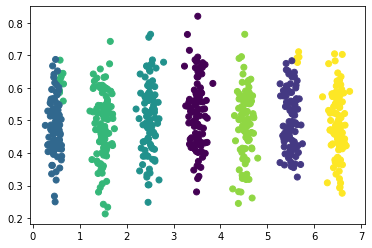

0.8205175399780273


In [13]:
import time

seed(0.03)

particles = 20
iterations = 100
c = 7
w = 0.99
c1 = 0.15
c2 = 0.15

n = 100
data = numpy.array(random_data(n, c))
# data = numpy.array([[0.5, 0.5], [1.5, 0.5], [2.5, 0.5], [3.5, 0.5], [4.5, 0.5]])

start = time.time()

BLOCKDIM = 64
DATADIM = 2
main_GPU(data, particles=particles, iterations=iterations, c=c, w=w, c1=c1, c2=c2, blockdim=BLOCKDIM)

end = time.time() - start
print(end)

# CPU CODE

In [493]:
def fitness_CPU(particles_pos, data, index):
    data_dim = len(data[0])
    particle = particles_pos[index]
    sum_dists = 0
    for point in range(len(data)):
        min_dist = float('inf')
        for centroid in range(0, len(particle), data_dim):
            dist = 0
            for k in range(data_dim):
                dist += (data[point][k] - particle[centroid + k]) ** 2
            if(dist < min_dist):
                min_dist = dist
        sum_dists += min_dist
    return sum_dists

def update_CPU(particles_pos, particles_vel, particles_best_pos, global_best_pos, i, w, c1, c2):
    r1, r2 = random(), random()
    for d in range(len(particles_pos[i])):
        particles_vel[i][d] = w * particles_vel[i][d] + c1 * r1 * (particles_best_pos[i][d] - particles_pos[i][d]) + c2 * r2 * (global_best_pos[d] - particles_pos[i][d])
        particles_pos[i][d] += particles_vel[i][d]

def main_CPU(
        data,
        n = 10000,
        particles = 10000,
        iterations = 100,
        c = 3,
        w = 0.99,
        c1 = 0.3,
        c2 = 0.3,
        blockdim = 64
    ):
  
    # c = 3
    # n = 100
    # particles = 10
    # iterations = 100
    # w = 0.99
    # c1 = 0.3
    # c2 = 0.3
    
    # data = numpy.array(random_data(n, c))
    
    particles_pos, particles_vel = init_particles(particles, c, data)
    particles_best_pos = [i.copy() for i in particles_pos]
    particles_best_fit = [float('inf') for i in range(len(particles_pos))]
    particles_pos = numpy.array(particles_pos)


    global_best_fit = float('inf')
    global_best_pos = None
    global_best_index = -1

    for iter in range(iterations):
        for p in range(len(particles_pos)):
            fitness_p = fitness_CPU(particles_pos, data, p)
            if(fitness_p < particles_best_fit[p]):
                particles_best_fit[p] = fitness_p
                particles_best_pos[p] = particles_pos[p].copy()
            if(fitness_p < global_best_fit):
                global_best_fit = fitness_p
                global_best_pos = particles_pos[p].copy()
                global_best_index = p

        for p in range(len(particles_pos)):
            update_CPU(particles_pos, particles_vel, particles_best_pos, global_best_pos, p, w, c1, c2)
    
    for i in range(global_best_index, global_best_index + 1):
        l = []
        for point in data:
            min_dist = float('inf')
            min_value = None
            for centroid in range(0, len(particles_best_pos[i]), len(data[0])):
                dist = 0
                for k in range(len(data[0])):
                    dist += (point[k] - particles_best_pos[i][centroid + k]) ** 2
                if dist < min_dist:
                    min_dist = dist
                    min_value = centroid // len(data[0])
            l.append(min_value)
        
        plt.scatter(*zip(*data), c = l)
        plt.show()    

chal rha hai


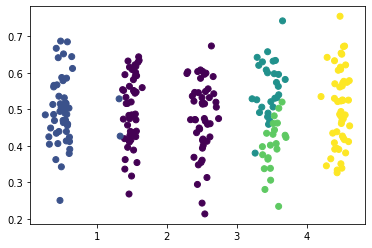

0.15741801261901855


In [494]:
import time

seed(0.03)

particles = 10
iterations = 1
c = 5
w = 0.99
c1 = 0.15
c2 = 0.2

n = 50
data = numpy.array(random_data(n, c))

start = time.time()

BLOCKDIM = 64
DATADIM = 2
main_CPU(data, particles=particles, iterations=iterations, c=c, w=w, c1=c1, c2=c2, blockdim=BLOCKDIM)

end = time.time() - start
print(end)